In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import statsmodels.api as sm
import statsmodels.tsa.api as tsa

from datamodel import SPX, StockData

from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler

plt.rcParams["figure.figsize"] = (15,10)

In [2]:
from abc import ABC, abstractmethod

class Model:
    """
    All model objects used for WalkForwardAnalysis must have these methods
    """
    @abstractmethod
    def fit(self, train_indep_var, train_dep_var):
        """
        Fit model using training data.
        """
        pass
    
    @abstractmethod
    def loss(self, test_indep_var, test_dep_var):
        """
        Return object containing loss metrics using testing data.
        """
        pass

class WalkForwardAnalysis:
    """
    Conducts walk forward testing for time series models. Splits dataset into 'splits' number of parts.
    Train data is an expanding window.
    splits: number of splits to use for cross validation
    min_samples: minimum number of samples to include for training in the first split
    """
    def __init__(self, indep_var, dep_var, model, splits=10, min_samples=52):
        if len(indep_var) != len(dep_var):
            raise ValueError("Independent variable and dependent variable must have same length")
        self.indep_var = indep_var
        self.dep_var = dep_var
        self.model = model
        self.splits = splits
        self.min_samples = min_samples
    
    def index_gen(self):
        """
        Generates indexing numbers for training and testing data
        """
        split_length = (len(self.indep_var) - self.min_samples) // self.splits
        for t in range(self.splits - 1):
            if t == 0:
                train_index = self.min_samples
            else:
                train_index = self.min_samples + (split_length * t)
            # When we're on the last test split, use entire rest of dataset.
            # This fixes rounding issues between number of splits and length of dataset.
            if t == (self.splits - 2):
                test_index = len(indep_var)
            else:
                test_index = train_index + split_length
            yield t, train_index, test_index
        
    def walk_forward_test(self):
        """
        Conducts walk forward test.
        Returns: list of objects returned from model's 'loss' function
        """
        results = []
        for t, train_index, test_index in self.index_gen():
            train_indep_var = self.indep_var.iloc[:train_index]
            train_dep_var = self.dep_var.iloc[:train_index]
            self.model.fit(train_indep_var, train_dep_var)
            
            test_indep_var = self.indep_var.iloc[train_index:test_index]
            test_dep_var = self.dep_var.iloc[train_index:test_index]
            results.append(self.model.loss(test_indep_var, test_dep_var))
            print(f"Split {t} complete.")
        return results

In [117]:
class RidgeModel(Model):
    def __init__(self):
        self.model = linear_model.RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10], cv=TimeSeriesSplit(), scoring="neg_mean_squared_error")
        self.scaler = RobustScaler()
    
    def fit(self, train_indep_var, train_dep_var):
        self.scaler.fit(train_indep_var)
        self.model.fit(self.scaler.transform(train_indep_var), train_dep_var)
        
    def loss(self, test_indep_var, test_dep_var):
        predicted_values = pd.Series(self.model.predict(self.scaler.transform(test_indep_var)), index=test_indep_var.index)
        result = {"loss": self.model.score(self.scaler.transform(test_indep_var), test_dep_var),
                  "predicted": predicted_values,
                  "residuals": test_dep_var - predicted_values,
                  "coef": self.model.coef_,
                  "intercept": self.model.intercept_}
        return result

In [6]:
def create_lags(series, lags, name="x"):
    """
    Creates a dataframe with lagged values of the given series.
    Generates columns named x_t-n which means the value of each row is the value of the original
    series lagged n times

    series: Pandas series
    lags: number of lagged values to include
    name: String to put as prefix for each column name

    Returns: Pandas dataframe
    """
    result = pd.DataFrame(index=series.index)
    result[f"{name}_t"] = series

    for n in range(lags):
        result[f"{name}_t-{n+1}"] = series.shift(n + 1)

    return result

In [7]:
spx = SPX()
data = StockData(["^VIX"])

spx_wk_prices = spx.prices.resample("W-FRI").last()
spx_wk_returns = (np.log(spx_wk_prices) - np.log(spx_wk_prices.shift(1))).dropna()
spx_wk_vol = np.sqrt(spx.vol.resample("W-FRI").sum())

In [8]:
stats.normaltest((spx_wk_returns / spx_wk_vol).dropna())

NormaltestResult(statistic=3.569877139991185, pvalue=0.1678073690909926)

In [9]:
stats.normaltest(spx_wk_returns)

NormaltestResult(statistic=311.493767285131, pvalue=2.290803618303192e-68)

In [10]:
spx_vol_lags = create_lags(np.log(np.sqrt(spx.vol)), 21, "spx_vol").dropna()
vix_lags = create_lags(np.log(data.prices.VIX["close"]), 21, "vix")
spx_return_lags = create_lags(spx.returns, 21, "spx_returns")

indep_var = pd.concat([spx_vol_lags, vix_lags, spx_return_lags], axis=1).dropna()
dep_var = np.log(spx_wk_vol.shift(-1).dropna())

common_index = indep_var.index.intersection(dep_var.index)

indep_var = indep_var.loc[common_index]
dep_var = dep_var.loc[common_index]

In [87]:
model = RidgeModel()
model_test = WalkForwardAnalysis(indep_var, dep_var, model, splits=25, min_samples=130)
results = model_test.walk_forward_test()

loss = [n["loss"] for n in results]
predicted = pd.concat([n["predicted"] for n in results])
resids = pd.concat([n["residuals"] for n in results])

Split 0 complete.
Split 1 complete.
Split 2 complete.
Split 3 complete.
Split 4 complete.
Split 5 complete.
Split 6 complete.
Split 7 complete.
Split 8 complete.
Split 9 complete.
Split 10 complete.
Split 11 complete.
Split 12 complete.
Split 13 complete.
Split 14 complete.
Split 15 complete.
Split 16 complete.
Split 17 complete.
Split 18 complete.
Split 19 complete.
Split 20 complete.
Split 21 complete.
Split 22 complete.
Split 23 complete.


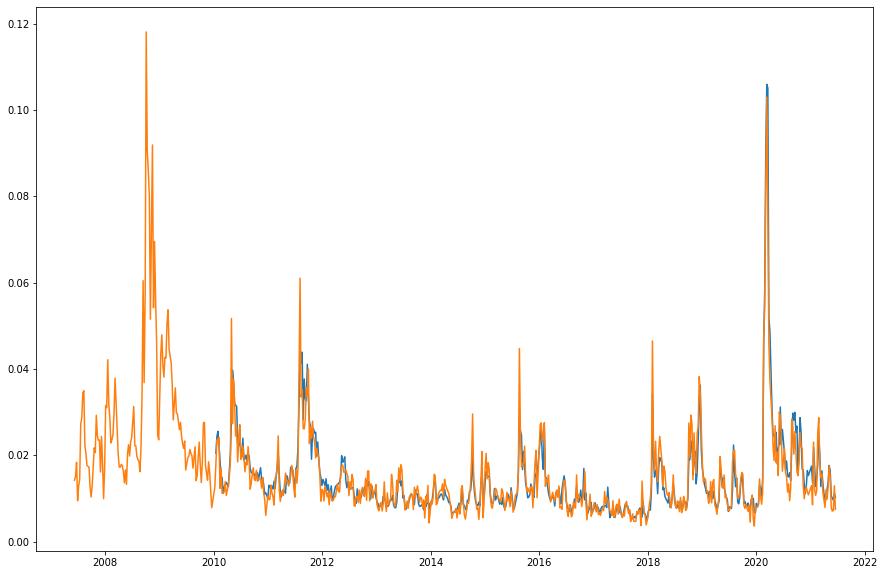

In [88]:
plt.plot(np.exp(predicted))
plt.plot(np.exp(dep_var))

In [89]:
np.mean(loss)

0.6136876359482689

In [91]:
stat, pvalue = sm.stats.acorr_ljungbox(resids, 52)

/home/eadains/VolatilityTrading/venv/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [92]:
pvalue < .05

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [93]:
stats.normaltest((spx_wk_returns / np.exp(predicted)).dropna())

NormaltestResult(statistic=2.903739669124352, pvalue=0.23413209026825169)